In [5]:
import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Imputation libraries
import scprep # preprocessing
import saver
import magic
import scanpy as sc

from scipy.stats import spearmanr

# Clustering libraries
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import anndata

from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
#https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_04_clustering.html

# Step 0: Download the training data

In [6]:
path_data = "data/"
results_path = "results"
archive_name = "CarballoCastro_Alba.zip"

In [7]:
bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")
sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")

sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

In [8]:
print(f"Number of patients in the train dataset {bulk_pancreas.shape[1]}")
print(f"Number of genes in the dataset {bulk_pancreas.shape[0]}")

assert bulk_pancreas.shape[0] == sc_pancreas.shape[0]
print(f"Number of cells in the train dataset {sc_pancreas.shape[1]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453
Number of cells in the train dataset 978


In [9]:
print(f"Number of cells in the test dataset {sc_pancreas_test.shape[1]}")

Number of cells in the test dataset 789


In [10]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [11]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [12]:
print(f"There are {sc_pancreas_metadata.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {sc_pancreas_metadata.Celltype.unique()}")

There are 13 different cell types in the dataset
The different cells types are ['acinar cell' 'alpha cell' 'gamma cell' 'delta cell'
 'unclassified endocrine cell' 'beta cell' 'ductal cell'
 'endothelial cell' 'co-expression cell' 'PSC cell' 'epsilon cell'
 'MHC class II cell' 'mast cell']


In [13]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [14]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


In [15]:
# We will log transform the data 
sc_pancreas_norm = scprep.transform.log(sc_pancreas)
bulk_pancreas_norm = scprep.transform.log(bulk_pancreas)

In [16]:
#Create a train and validation set to test out performance

sc_pancreas_shuff, bulk_pancreas_shuff= shuffle(sc_pancreas_norm, bulk_pancreas_norm, random_state=42)
sc_train, sc_val, bulk_train, bulk_val = train_test_split(sc_pancreas_shuff, bulk_pancreas_shuff, random_state=42, test_size= 0.2)

In [17]:
print(f'Train shape for single cell is {sc_train.shape}')
print(f'Validation shape for single cell is {sc_val.shape}')
print(f'Train shape for bulk is {bulk_train.shape}')
print(f'Validation shape for bulk cell is {bulk_val.shape}')

Train shape for single cell is (20362, 978)
Validation shape for single cell is (5091, 978)
Train shape for bulk is (20362, 4)
Validation shape for bulk cell is (5091, 4)


In [18]:
#Check if we have genes with the same name
index = sc_train.index
unique_genes = index.unique

# Step 1: Perform the imputation

### Data preprocessing

* Filtering: we see that data is prefiltered
* Normalization: log transform with pseudocount
* Removing unexpressed genes? -> MAGIC recomienda pero según las guidelines no se debe eliminar ningún gen

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: xlabel='Library size', ylabel='Number of cells'>

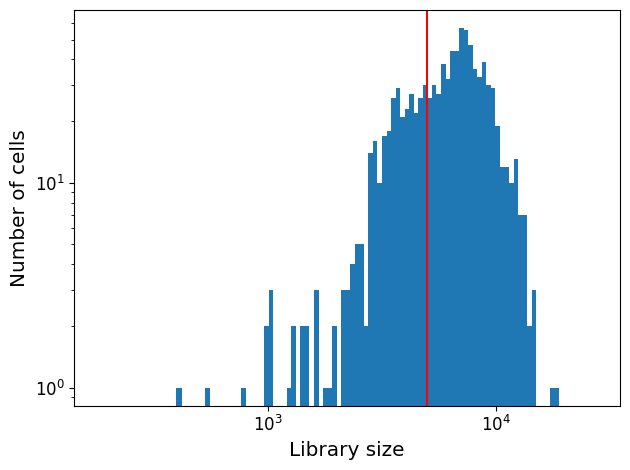

In [19]:
scprep.plot.plot_library_size(sc_train.transpose(), cutoff=5000)

In [20]:
print(sc_train.shape)

(20362, 978)


In [21]:
#sc_pancreas_norm = scprep.normalize.library_size_normalize(sc_pancreas.transpose())
#sc_pancreas_norm = scprep.transform.sqrt(sc_pancreas_norm)

In [22]:
#We will log-transform our data as they evaluate on this kind of data
#sc_train_norm =

### Imputation using MAGIC

In [23]:
magic_op = magic.MAGIC()

In [24]:
#Apply MAGIC in the whole training data
pancreas_magic = magic_op.fit_transform(sc_pancreas_shuff.transpose())

Calculating MAGIC...
  Running MAGIC on 978 cells and 25453 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 3.62 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.13 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 3.84 seconds.
  Running MAGIC with `solver='exact'` on 25453-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.37 seconds.
Calculated MAGIC in 4.28 seconds.


In [25]:
train_magic = magic_op.fit_transform(sc_train.transpose())

Calculating MAGIC...
  Running MAGIC on 978 cells and 20362 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 3.52 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 3.71 seconds.
  Running MAGIC with `solver='exact'` on 20362-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.29 seconds.
Calculated MAGIC in 4.09 seconds.


In [26]:
val_magic = magic_op.transform(sc_val.transpose())

Calculating imputation...
Calculated imputation in 0.15 seconds.


/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


In [27]:
#We will create the bulkified matrix to compare the bulk with the imputed data.
#In the bulk matrix we just have one measurement per patient per gene. 
#In the sc data we need to compute the average over each cell for each patient and gene
assert sc_pancreas_metadata.shape[0] == train_magic.shape[0]
train_merged = sc_pancreas_metadata.join(train_magic, on='Source Name')
train_bulkified = train_merged.groupby('Sample', as_index= False).mean().transpose().tail(-1)
train_bulkified.columns = ["patient1","patient2","patient3","patient4"]
train_bulkified.index = sc_train.index 

#We bulkify also the validation dataset
val_merged = sc_pancreas_metadata.join(val_magic, on= 'Source Name')
val_bulkified = val_merged.groupby('Sample', as_index=False).mean().transpose().tail(-1)
val_bulkified.columns = ["patient1","patient2","patient3","patient4"]
val_bulkified.index = sc_val.index 

In [28]:
print(f'Train bulkified matrix shape is : {train_bulkified.shape}')
print(f'Train bulk matrix shape is : {bulk_train.shape}')

Train bulkified matrix shape is : (20362, 4)
Train bulk matrix shape is : (20362, 4)


In [29]:
print(f'Validation bulkified matrix shape is : {val_bulkified.shape}')
print(f'Validation bulk matrix shape is : {bulk_val.shape}')

Validation bulkified matrix shape is : (5091, 4)
Validation bulk matrix shape is : (5091, 4)


In [30]:
#bulkified_magic = sc_pancreas_metadata.join(pancreas_magic, on="Source Name").groupby('Sample', as_index=False).mean().transpose().tail(-1)
#bulkified_magic.columns = ["patient1","patient2","patient3","patient4"]
#bulkified_magic.index = sc_pancreas.index

### Spearman

In [31]:
# MAGIC
corr, pval = spearmanr(bulk_train, train_bulkified)
spearman = corr.mean()
print(f'Spearman correlation for train is {spearman}')

corr_val, pval_val = spearmanr(bulk_val, val_bulkified)
spearman_val = corr_val.mean()
print(f'Spearman correlation for validation is {spearman_val}')

Spearman correlation for train is 0.9585866972412922
Spearman correlation for validation is 0.9571391067855481


In [32]:
#TODO: train magic with all the train data, predict on test and provide the file in the final format
#We need to log transform the data

# Step 2: Perform clustering 

In [33]:
cell_labels = sc_pancreas_metadata['Celltype']
encoder = LabelEncoder()
encoded_label = encoder.fit_transform(cell_labels)
decoded_label = encoder.inverse_transform(encoded_label)
true_labels = encoded_label

### Clustering on ICA reduced data

In [34]:
#Try PCA reduction prior to clustering

#pca = PCA(n_components=20)
#pancreas_pca = pca.fit_transform(pancreas_magic) 
#print(pancreas_pca.shape)
# Print the total explained variance
#print('Total explained variance:', np.sum(pca.explained_variance_ratio_))

#Try with ICA 
ica = FastICA(n_components=20)
pancreas_ica = ica.fit_transform(pancreas_magic) 
print(pancreas_ica.shape)
# Print the total explained variance
#print('Total explained variance:', np.sum(pca.explained_variance_ratio_))

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


(978, 20)


In [35]:
#Now do the k means on this 
kmeans = KMeans(n_clusters=13, random_state=42)
clusters_pca = kmeans.fit_predict(pancreas_ica) # TODO: Add the +1 in the end not now

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


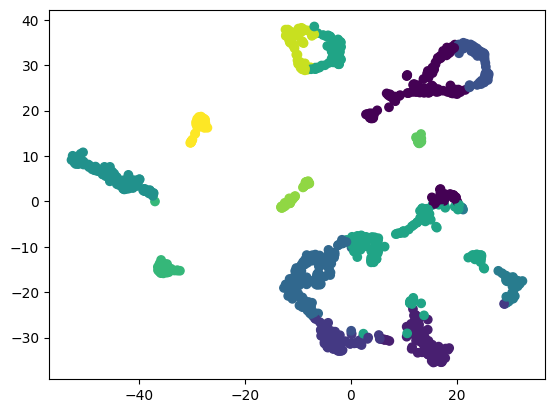

In [36]:
#Visualize clustering with a tsne map
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
visualization_tsne = tsne.fit_transform(pancreas_ica)
fig, ax = plt.subplots()
scatter = ax.scatter(visualization_tsne[:,0], visualization_tsne[:,1], c= clusters_pca, label = clusters_pca)

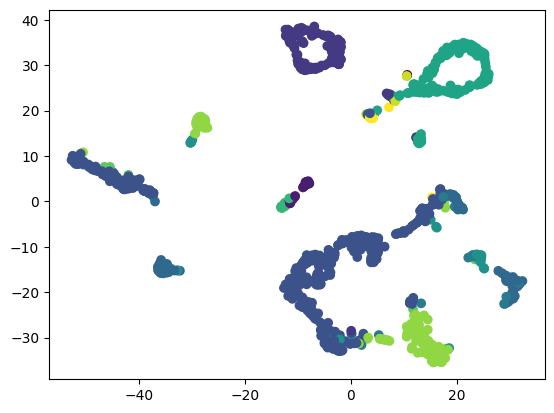

In [37]:
#Visualize real cell types with tsne
fig, ax = plt.subplots()
count=0
scatter = ax.scatter(visualization_tsne[:,0], visualization_tsne[:,1], c= encoded_label, label = encoded_label)

In [38]:
#Evaluate
pca_50 = PCA(n_components=50)
pancreas_pca_50 = pca_50.fit_transform(pancreas_magic) 

ssc = silhouette_score(pancreas_pca_50, clusters_pca)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(true_labels, clusters_pca)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(true_labels, clusters_pca)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

Silhouette score: 0.251661620536358
Adjusted Rand Index: 0.3128440059128941
V-Measure score: 0.5875699579803496
Performance: 0.3840251948098672


In [ ]:
#Check that the encoded labels match with the real labels and that we have the same number of them
decoded_set = set(np.ndarray.tolist(decoded_label))
df = pd.DataFrame(encoded_label)
print(df.iloc[:,0].value_counts())
print(sc_pancreas_metadata['Celltype'].value_counts())


3     378
7     160
10    124
2     119
4      91
6      29
1      26
5      17
12     15
8      10
9       5
0       2
11      2
Name: 0, dtype: int64
alpha cell                     378
ductal cell                    160
gamma cell                     124
acinar cell                    119
beta cell                       91
delta cell                      29
PSC cell                        26
co-expression cell              17
unclassified endocrine cell     15
endothelial cell                10
epsilon cell                     5
MHC class II cell                2
mast cell                        2
Name: Celltype, dtype: int64


### Clustering on MAGIC transformed data

In [72]:
# Perform t-SNE dimensionality reduction on imputed data.
#For t-sne I think we need to transpose the data because we are interested in patient cells and not on all the genes. 
#Right now what is happening is that it is keeping all the genes but reducing the patient cells

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
train_tsne = tsne.fit_transform(pancreas_magic)

In [40]:
pca = PCA(n_components=50)
pancreas_pca = pca.fit_transform(pancreas_magic) #TODO: check if this is what they mean

print('Total explained variance:', np.sum(pca.explained_variance_ratio_))

Total explained variance: 0.9980113335032055


In [43]:
print(train_tsne.shape)
print(f'I have {len(sc_pancreas_metadata["Celltype"].unique())} different cell types, so I will have these cluster labels')

(978, 2)
I have 13 different cell types, so I will have these cluster labels


In [66]:
# Perform K-means clustering
#TODO: Change clustering method
kmeans = KMeans(n_clusters=13, random_state=42)
clusters = kmeans.fit_predict(train_tsne) # TODO: Add the +1 in the end not now

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [69]:
print(clusters.shape)
print(train_tsne.shape)
print(set(np.ndarray.tolist(clusters)))
print(set(np.ndarray.tolist(encoded_label)))
#The number of clusters is 12 as expected
#TODO: how to change back to the cell type labels
print(decoded_label.shape)

(978,)
(978, 50)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
(978,)


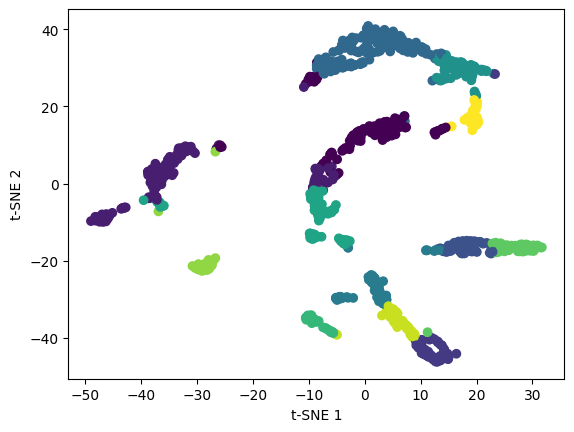

In [68]:
# Plot t-SNE visualization with cluster assignments
plt.scatter(train_tsne[:,0], train_tsne[:,1], c=clusters)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

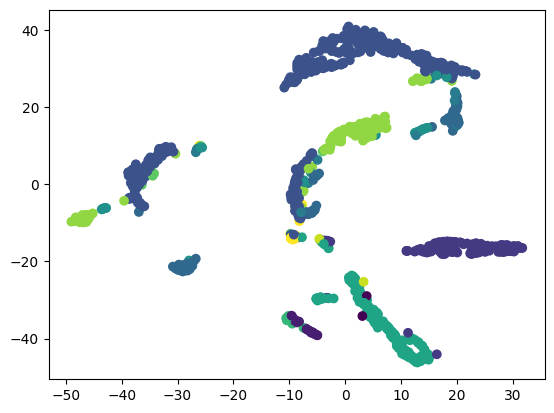

In [64]:
fig, ax = plt.subplots()
count=0
""""
for color in zip(encoded_label):
    x= train_tsne[count, 0]
    y = train_tsne[count, 1]
    ax.scatter(x,y,c= color[0])
    count +=1
#plt.scatter(train_tsne[:,0], train_tsne[:,1], c=encoded_label)
ax.legend(decoded_set)
"""
scatter = ax.scatter(train_tsne[:,0], train_tsne[:,1], c= encoded_label, label = encoded_label)

In [47]:
cluster_labels = pd.DataFrame(data = {'index': sc_pancreas.columns, 'cluster': clusters})

In [70]:
ssc = silhouette_score(pancreas_pca, clusters)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(true_labels, clusters)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(true_labels, clusters)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

Silhouette score: 0.4188443141780716
Adjusted Rand Index: 0.3240667020690818
V-Measure score: 0.5593022456909523
Performance: 0.4340710873127019


### PCA Dataframe

In [49]:
PCA_df = pd.DataFrame(data = pancreas_pca, columns = ["PC"+str(i+1) for i in range(50)])
print(PCA_df.shape)
PCA_df.insert(loc=0, column='index', value=sc_pancreas_shuff.columns)
print(PCA_df)

(978, 50)
            index        PC1        PC2        PC3        PC4       PC5  \
0    patient1_A10  39.490681 -20.499043  10.986668  10.927416 -3.109414   
1    patient1_A12   4.717423  20.595693  -0.277624  -0.439507 -7.033983   
2    patient1_A13   0.291647  16.357360   1.592786  -3.183454  7.022762   
3    patient1_A15  -2.321775  15.283787   1.380685  -3.231049  6.960572   
4    patient1_A17  -4.652297  13.740515   2.381843  -4.307614  6.516131   
..            ...        ...        ...        ...        ...       ...   
973   patient4_P5 -39.715698  -9.969509   6.758491 -10.204981  1.756090   
974   patient4_P6 -22.410125   1.621995   5.225262  -8.089692 -1.295003   
975   patient4_P7  27.927174  26.581637   1.586859  -1.414822 -1.906928   
976   patient4_P8  44.413107  27.502105   2.433108  -1.317397 -0.623382   
977   patient4_P9 -30.345743  -2.639151   5.941460  -9.337001 -0.719281   

          PC6        PC7       PC8       PC9  ...      PC41      PC42  \
0   -1.577474   

### Scanpy tutorial for clustering on NOT imputed data

In [50]:
sc_pancreas = sc.read(os.path.join(path_data,"train_data","pancreas_sc_train.csv"))

In [51]:
sc_pancreas_t= sc_pancreas.transpose()

In [52]:
sc_pancreas_t.obs['cell_type'] = sc_pancreas_metadata['Celltype']
sc_pancreas_t.var_names_make_unique()

In [53]:
sc_pancreas_t

AnnData object with n_obs × n_vars = 978 × 25453
    obs: 'cell_type'

In [54]:
sc.pp.log1p(sc_pancreas_t)
sc_pancreas_t.raw = sc_pancreas_t

In [55]:
sc.tl.pca(sc_pancreas_t, n_comps= 20)

In [56]:
sc.pp.neighbors(sc_pancreas_t, n_neighbors=10, n_pcs=20)

In [57]:
sc.tl.umap(sc_pancreas_t)

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


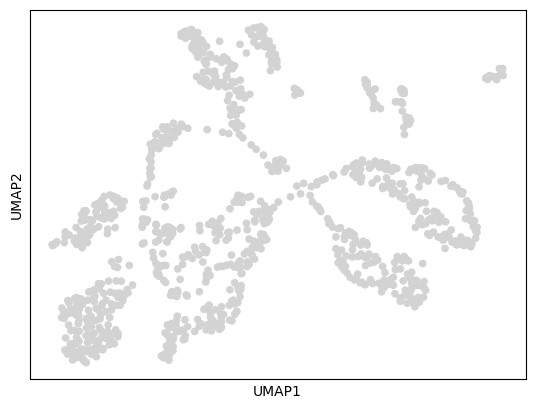

In [58]:
sc.pl.umap(sc_pancreas_t,use_raw=True)

In [59]:
sc.tl.leiden(sc_pancreas_t, resolution =0.40005)

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


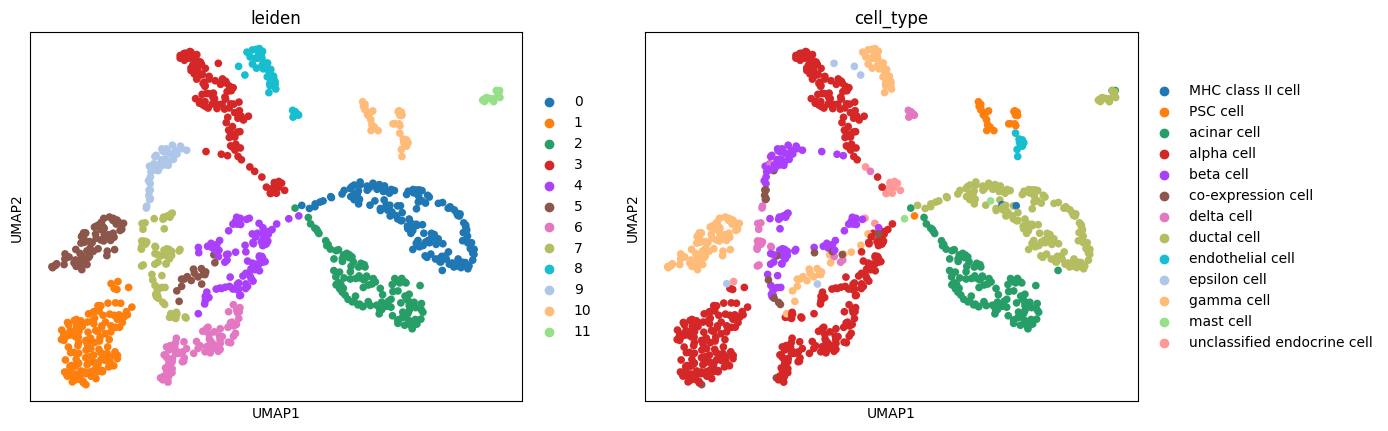

In [60]:
sc.pl.umap(sc_pancreas_t, color=['leiden', 'cell_type'])

In [61]:
#Obtain labels from leiden clustering
leiden_labels = sc_pancreas_t.obs['leiden']
leiden_l = np.empty((978,), dtype=int)
for i in range(978):
    value= leiden_labels[i]
    leiden_l[i]= value


In [62]:
#Compute PCA space to evaluate silhuoette coefficie
sc.tl.pca(sc_pancreas_t, n_comps= 50)
pca_matrix_50 = sc_pancreas_t.obsm['X_pca']
#El resultado es

In [63]:
ssc = silhouette_score(pca_matrix_50, leiden_l)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(encoded_label, leiden_l)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(encoded_label, leiden_l)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

Silhouette score: 0.09669445
Adjusted Rand Index: 0.47654318626591646
V-Measure score: 0.6920866225624616
Performance: 0.42177475197618014


# Step 3: Predict on the test data

Cuando decidamos qué tecnicas de imputación y clustering son mejores, hacerlo en los datos de test.

# Step 4: Save the required files

In [ ]:
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
# bulkified.columns = ["patient5","patient6","patient7"]
# bulkified.index = sc_pancreas_test.index

In [ ]:
# assert all(bulkified.columns == ["index","patient5","patient6","patient7"])
# assert all(bulkified["index"] == sc_pancreas_test.index)

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(cluster_labels.columns == ["index","cluster"])
# assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [ ]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])
# assert all(PCA["index"] == sc_pancreas_test.columns)

In [ ]:
# with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
#     with zf.open(f"imputed_bulkified.csv", "w") as buffer:
#         bulkified.to_csv(buffer)
#     with zf.open(f"cluster_membership.csv", "w") as buffer:
#         cluster_labels.to_csv(buffer)
#     with zf.open(f"PCA.csv", "w") as buffer:
#         PCA.to_csv(buffer)
#     zf.close()

In [ ]:
# archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
# assert all(
#         [
#             i in archive.namelist()
#             for i in [
#                 "imputed_bulkified.csv",
#                 "cluster_membership.csv",
#                 "PCA.csv",
#             ]
#         ]
#     )